In [1]:
!pip install open3d
!git clone https://github.com/guochengqian/openpoints.git
!git clone https://github.com/guochengqian/PointNeXt.git
!pip install shortuuid
!pip install plyfile
!pip install easydict

fatal: destination path 'openpoints' already exists and is not an empty directory.
fatal: destination path 'PointNeXt' already exists and is not an empty directory.


In [2]:
!pip install torch multimethod termcolor tensorboard

In [3]:
# from openpoints.transforms import (Compose, RandomRotate, 
#            RandomFlip, RandomScale, RandomShift, RandomJitter, PointsToTensor)

from openpoints.transforms import (Compose, PointCloudXYZAlign, 
           RandomHorizontalFlip, PointCloudScaling, PointCloudTranslation, PointCloudJitter, 
PointCloudCenterAndNormalize, PointCloudToTensor)

from openpoints.utils import ConfusionMatrix

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.neighbors import NearestNeighbors
import numpy as np
import open3d as o3d
from plyfile import PlyData
import os
import glob
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Visualization

Shape of point cloud: (81369, 3)
Shape of colors: (81369, 3)


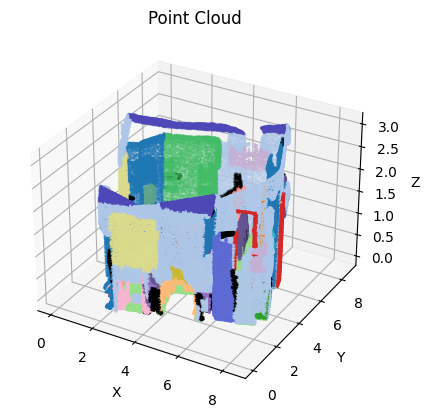

In [4]:
# Đọc file .ply
ply_file = "/home/tm/Desktop/dense_caption/scans/scene0000_00/scene0000_00_vh_clean_2.labels.ply"
plydata = PlyData.read(ply_file)

vertex = plydata['vertex']
points = np.vstack([vertex['x'], vertex['y'], vertex['z']]).T  # (N, 3)
colors = np.vstack([vertex['red'], vertex['green'], vertex['blue']]).T / 255.0  # (N, 3)
labels = np.array(vertex['label'])  # (N,)


# Kiểm tra kích thước
print(f"Shape of point cloud: {points.shape}")
print(f"Shape of colors: {colors.shape}")

# Vẽ point cloud với màu sắc gốc sử dụng matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Lấy tọa độ x, y, z
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

# Vẽ các điểm với màu sắc tương ứng
ax.scatter(x, y, z, c=colors, s=1)  # vẽ các điểm với màu sắc RGB và kích thước nhỏ
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Point Cloud')

plt.show()

Shape of point cloud: (81369, 3)
Shape of colors: (81369, 3)


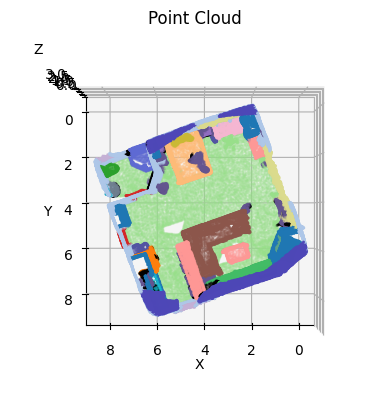

In [5]:
# Đọc file .ply
ply_file = "/home/tm/Desktop/dense_caption/scans/scene0000_00/scene0000_00_vh_clean_2.labels.ply"
plydata = PlyData.read(ply_file)

vertex = plydata['vertex']
points = np.vstack([vertex['x'], vertex['y'], vertex['z']]).T  # (N, 3)
colors = np.vstack([vertex['red'], vertex['green'], vertex['blue']]).T / 255.0 # (N, 3)
labels = np.array(vertex['label'])  # (N,)

# Lấy tọa độ và màu sắc của các điểm trong point cloud
# pcd_array = np.asarray(pcd.points)  # Tọa độ các điểm
# colors_array = np.asarray(pcd.colors)  # Màu sắc các điểm (RGB)

# Kiểm tra kích thước
print(f"Shape of point cloud: {points.shape}")
print(f"Shape of colors: {colors.shape}")

# Vẽ point cloud với màu sắc gốc sử dụng matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Lấy tọa độ x, y, z
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

# Lấy màu sắc của các điểm
colors = colors  # Mỗi điểm có màu RGB (N, 3)

# Vẽ các điểm với màu sắc tương ứng
ax.scatter(x, y, z, c=colors, s=1)  # vẽ các điểm với màu sắc RGB và kích thước nhỏ
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Point Cloud')

# Thiết lập góc nhìn từ trên xuống (góc nhìn từ trục Z)
ax.view_init(elev=90, azim=90)  # elev=90: góc nhìn từ trên xuống, azim=90: xoay 90 độ quanh trục Z

# Hiển thị plot
plt.show()

Shape of point cloud: (81369, 3)
Shape of colors: (81369, 3)


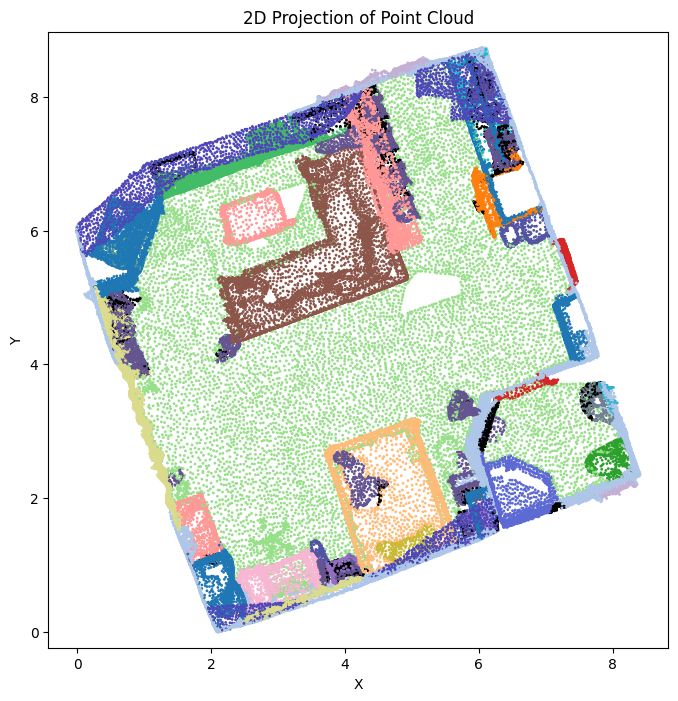

In [6]:
# Đọc file .ply
ply_file = "/home/tm/Desktop/dense_caption/scans/scene0000_00/scene0000_00_vh_clean_2.labels.ply"
plydata = PlyData.read(ply_file)

vertex = plydata['vertex']
points = np.vstack([vertex['x'], vertex['y'], vertex['z']]).T  # (N, 3)
colors = np.vstack([vertex['red'], vertex['green'], vertex['blue']]).T / 255.0  # (N, 3)
labels = np.array(vertex['label'])  # (N,)

# Kiểm tra kích thước
print(f"Shape of point cloud: {points.shape}")
print(f"Shape of colors: {colors.shape}")

# Chiếu các điểm lên mặt phẳng XY (giữ lại x và y, bỏ qua z)
pcd_2d = points[:, :2]  # Lấy x và y làm tọa độ 2D

# Vẽ point cloud dưới dạng 2D với matplotlib
plt.figure(figsize=(8, 8))
plt.scatter(pcd_2d[:, 0], pcd_2d[:, 1], c=colors, s=1)  # vẽ các điểm với màu sắc RGB
plt.title('2D Projection of Point Cloud')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')  # Đảm bảo tỷ lệ trục x và y bằng nhau
plt.show()

## Scannet Dataset

In [7]:
NUM_CLASSES = 41
smooth_factor = 0.1
CLASS_LABELS = (
    "wall", "floor", "cabinet", "bed", "chair", "sofa", "table", "door", "window", "bookshelf",
    "picture", "counter", "desk", "curtain", "refrigerator", "shower curtain", "toilet", "sink",
    "bathtub", "otherfurniture",
)

SCANNET_COLOR_MAP = {
        0: (0.0, 0.0, 0.0),
        1: (174.0, 199.0, 232.0),
        2: (152.0, 223.0, 138.0),
        3: (31.0, 119.0, 180.0),
        4: (255.0, 187.0, 120.0),
        5: (188.0, 189.0, 34.0),
        6: (140.0, 86.0, 75.0),
        7: (255.0, 152.0, 150.0),
        8: (214.0, 39.0, 40.0),
        9: (197.0, 176.0, 213.0),
        10: (148.0, 103.0, 189.0),
        11: (196.0, 156.0, 148.0),
        12: (23.0, 190.0, 207.0),
        13: (255, 255, 0),    # Adding missing class 13 (yellow)
        14: (247.0, 182.0, 210.0),
        15: (66.0, 188.0, 102.0),
        16: (219.0, 219.0, 141.0),
        17: (140.0, 57.0, 197.0),
        18: (202.0, 185.0, 52.0),
        19: (51.0, 176.0, 203.0),
        20: (200.0, 54.0, 131.0),
        21: (92.0, 193.0, 61.0),
        22: (78.0, 71.0, 183.0),
        23: (172.0, 114.0, 82.0),
        24: (255.0, 127.0, 14.0),
        25: (91.0, 163.0, 138.0),
        26: (153.0, 98.0, 156.0),
        27: (140.0, 153.0, 101.0),
        28: (158.0, 218.0, 229.0),
        29: (100.0, 125.0, 154.0),
        30: (178.0, 127.0, 135.0),
        31: (255, 0, 0),       # Adding missing class 31 (red)
        32: (146.0, 111.0, 194.0),
        33: (44.0, 160.0, 44.0),
        34: (112.0, 128.0, 144.0),
        35: (96.0, 207.0, 209.0),
        36: (227.0, 119.0, 194.0),
        37: (213.0, 92.0, 176.0),
        38: (94.0, 106.0, 211.0),
        39: (82.0, 84.0, 163.0),
        40: (100.0, 85.0, 144.0),
    }

class ScannetDataset(Dataset):
    def __init__(self, root='/home/tm/Desktop/dense_caption/scans', is_train=True, transform=None, target_size=10000):
        self.root = root
        self.file = os.listdir(root)
        length = len(self.file)
        split_idx = int(0.9 * length)
        self.file = self.file[:split_idx] if is_train else self.file[split_idx:]
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.file)

    def resize_point_cloud(self, points, labels):
        num_points = points.shape[0]
        selected_indices = []

        # Ensure each class has at least one point
        unique_labels = np.unique(labels)
        for label in unique_labels:
            label_indices = np.where(labels == label)[0]
            selected_indices.append(np.random.choice(label_indices))
        
        selected_indices = np.array(selected_indices)
        
        if num_points > self.target_size:
            # Select at least one point per class plus random points
            remaining_indices = np.setdiff1d(np.arange(num_points), selected_indices)
            remaining_indices = np.random.choice(remaining_indices, self.target_size - len(selected_indices), replace=False)
            all_selected_indices = np.concatenate([selected_indices, remaining_indices])
            points, labels = points[all_selected_indices], labels[all_selected_indices]
        
        elif num_points < self.target_size:
            # Add random points to reach target_size
            nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(points)
            while points.shape[0] < self.target_size:
                idx = np.random.choice(num_points)
                point1 = points[idx]
                point2 = points[nbrs.kneighbors([point1], 2)[1][0][1]]
                new_point = (point1 + point2) / 2
                new_label = labels[idx]
                points = np.vstack((points, new_point))
                labels = np.append(labels, new_label)

            points, labels = points[:self.target_size], labels[:self.target_size]

        return points, labels

    def normalize_points(self, points):
        # Normalize 3D points to have zero mean and unit variance
        mean = points.mean(axis=0)
        std = points.std(axis=0)
        normalized_points = (points - mean) / (std + 1e-8)  # Avoid division by zero
        return normalized_points

    def __getitem__(self, idx):
        path = self.file[idx]
        ply_file = f"{self.root}/{path}/{path}_vh_clean_2.labels.ply"

        plydata = PlyData.read(ply_file)
        vertex = plydata['vertex']
        points = np.vstack([vertex['x'], vertex['y'], vertex['z']]).T  # (N, 3)
        labels = np.array(vertex['label'], dtype=np.int32)  # Convert to int32 immediately
        
        # Apply transforms if any
        if self.transform:
            points, labels = self.resize_point_cloud(points, labels)
            point_cloud_data = {'pos': points, 'labels': labels}
            point_cloud_data = self.transform(point_cloud_data)
            points = point_cloud_data['pos']
            labels = point_cloud_data['labels']
            
            # Only convert to tensor if not already one
            if not isinstance(points, torch.Tensor):
                points = torch.from_numpy(points).float()
            if not isinstance(labels, torch.Tensor):
                labels = torch.from_numpy(labels).long()
                
            points = points.permute(1, 0) if len(points.shape) > 1 else points  # (3, N)

        return points, labels

In [8]:
# train_transform = Compose([
#     RandomRotate(angle=[0, 0, 1]),
#     RandomFlip(p=0.8),
#     RandomScale(scale=[0.8, 1.2]),
#     # RandomShift(shift=[0.2, 0.2, 0.2]),
#     RandomJitter(jitter_sigma=0.01, jitter_clip=0.05),
#     PointsToTensor(),
# ])

# test_transform = Compose([
#     PointsToTensor()
# ])

In [9]:
train_transform = Compose([
    PointCloudToTensor(),
    PointCloudXYZAlign(gravity_dim=2),
    RandomHorizontalFlip(upright_axis='z', aug_prob=0.8),
    PointCloudScaling(scale=[0.8, 1.2]),
    PointCloudTranslation(shift=[0.2, 0.2, 0.2]),
    PointCloudJitter(jitter_sigma=0.01, jitter_clip=0.05),
    PointCloudCenterAndNormalize()
])

test_transform = Compose([
    PointCloudToTensor(),
    PointCloudCenterAndNormalize()
])

Shape of point cloud: (81369, 3)
Shape of colors: (81369, 3)


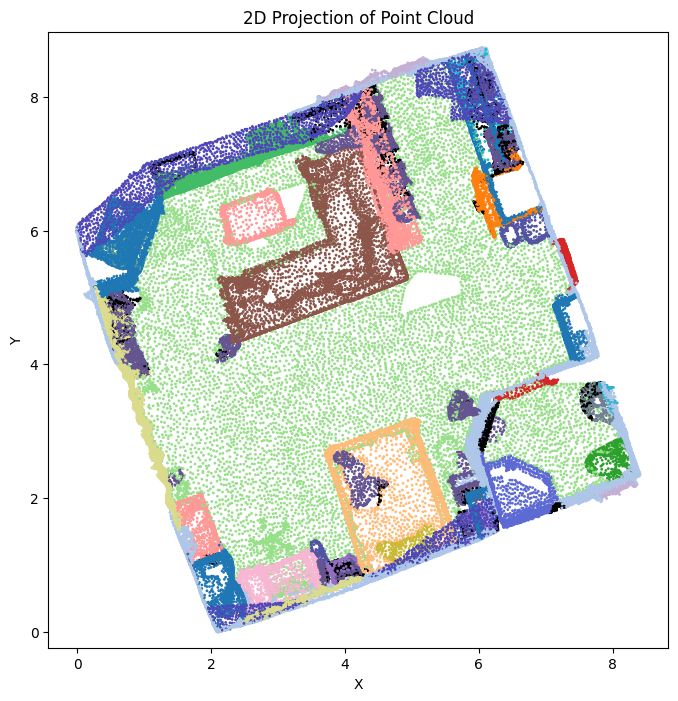

In [10]:
# Đọc file .ply
ply_file = "/home/tm/Desktop/dense_caption/scans/scene0000_00/scene0000_00_vh_clean_2.labels.ply"
pcd = o3d.io.read_point_cloud(ply_file)

# Lấy tọa độ và màu sắc của các điểm trong point cloud
pcd_array = np.asarray(pcd.points)  # Tọa độ các điểm
colors_array = np.asarray(pcd.colors)  # Màu sắc các điểm (RGB)

# Kiểm tra kích thước
print(f"Shape of point cloud: {pcd_array.shape}")
print(f"Shape of colors: {colors_array.shape}")

# Chiếu các điểm lên mặt phẳng XY (giữ lại x và y, bỏ qua z)
pcd_2d = pcd_array[:, :2]  # Lấy x và y làm tọa độ 2D

# Vẽ point cloud dưới dạng 2D với matplotlib
plt.figure(figsize=(8, 8))
plt.scatter(pcd_2d[:, 0], pcd_2d[:, 1], c=colors_array, s=1)  # vẽ các điểm với màu sắc RGB
plt.title('2D Projection of Point Cloud')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')  # Đảm bảo tỷ lệ trục x và y bằng nhau
plt.show()

(153498,)
(153498, 3)


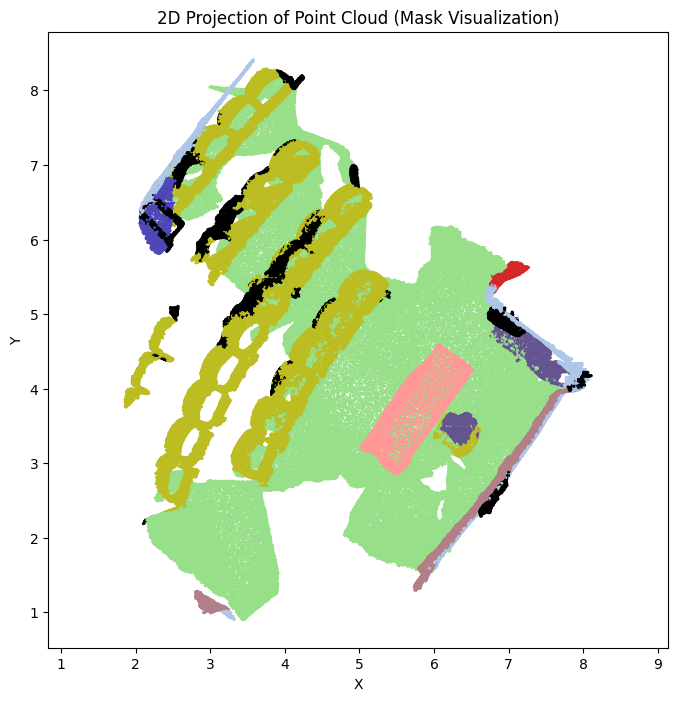

In [11]:
train_dataset = ScannetDataset()
points, mask = train_dataset[0]

print(mask.shape)
print(points.shape)

# Chuyển đổi màu sắc thành dạng (0-1) để matplotlib có thể sử dụng
colors = np.array([SCANNET_COLOR_MAP[m] for m in mask])

# Vẽ 2D projection của point cloud với mask
plt.figure(figsize=(8, 8))

# Vẽ các điểm với màu sắc từ SCANNET_COLOR_MAP
plt.scatter(points[:, 0], points[:, 1], c=colors / 255.0, s=1)

plt.title('2D Projection of Point Cloud (Mask Visualization)')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')  # Đảm bảo tỷ lệ trục x và y bằng nhau
plt.show()


torch.Size([10000])
torch.Size([3, 10000])


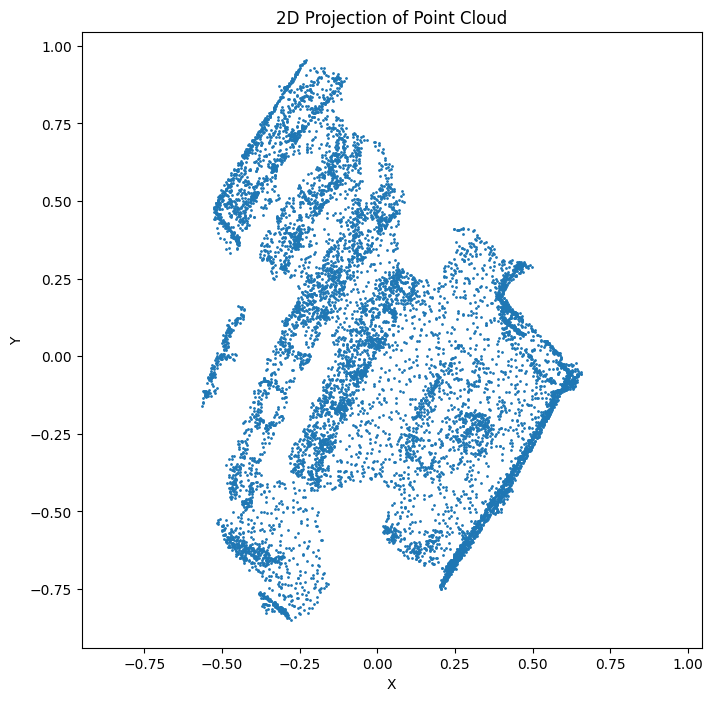

In [12]:
train_dataset = ScannetDataset(transform=train_transform)
points, mask = train_dataset[0]

print(mask.shape)
print(points.shape)


points = points.permute(1, 0)

# print(pcd_2d.shape, feature.shape)

# Vẽ point cloud dưới dạng 2D với matplotlib
plt.figure(figsize=(8, 8))
plt.scatter(points[:, 0], points[:, 1], s=1)  # vẽ các điểm với màu sắc RGB
plt.title('2D Projection of Point Cloud')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')  # Đảm bảo tỷ lệ trục x và y bằng nhau
plt.show()

In [13]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n = 1):
        self.val += val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou and val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
        plt.plot(epochs, val_mean_iou, 'b', label='Test Mean IoU')
        plt.title('Training and Test Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score and val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
        plt.plot(epochs, val_dice_score, 'b', label='Test Dice Score')
        plt.title('Training and Test Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

## Model

In [15]:
class TNet(nn.Module):
    def __init__(self, dim, num_points=10000):
        super().__init__()

        self.dim = dim
        self.layer1 = self._make_block_mlp(dim, 64)
        self.layer2 = self._make_block_mlp(64, 128)
        self.layer3 = self._make_block_mlp(128, 1024)

        self.max_pool = nn.MaxPool1d(num_points)

        self.layer4 = self._make_block_fc(1024, 512)
        self.layer5 = self._make_block_fc(512, 256)
        self.fc1 = nn.Linear(256, dim**2)
    
    def _make_block_mlp(self, in_dim, out_dim, kernel_size=1):
        return nn.Sequential(
            nn.Conv1d(in_dim, out_dim, kernel_size),
            nn.BatchNorm1d(out_dim),
            nn.ReLU()
        )
    
    def _make_block_fc(self, in_dim, out_dim, kernel_size=1):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        bs = x.shape[0]

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.max_pool(x).view(bs, -1)

        x = self.layer4(x)
        x = self.layer5(x)
        x = self.fc1(x)

        identity = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)

        if x.is_cuda:
            identity = identity.cuda()

        x = x.view(-1, self.dim, self.dim) + identity

        return x

In [16]:
class PointNetBackbone(nn.Module):
    def __init__(self, num_points=10000, num_global_features=1024):
        super().__init__()
        self.num_points = num_points

        self.TNet_1 = TNet(dim=3, num_points=num_points)
        self.TNet_2 = TNet(dim=64, num_points=num_points)

        self.layer1 = self._make_block(3, 64)
        self.layer2 = self._make_block(64, 64)

        self.layer3 = self._make_block(64, 64)
        self.layer4 = self._make_block(64, 128)
        self.layer5 = self._make_block(128, num_global_features)

        self.max_pool =nn.MaxPool1d(num_points, return_indices=True)

    def _make_block(self, in_dim, out_dim, kernel_size=1):
        return nn.Sequential(
            nn.Conv1d(in_dim, out_dim, kernel_size),
            nn.BatchNorm1d(out_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        bs = x.shape[0]

        A_input = self.TNet_1(x)

        x = torch.bmm(x.transpose(2, 1), A_input).transpose(2, 1)

        x = self.layer1(x)
        x = self.layer2(x)

        A_feat = self.TNet_2(x)

        x = torch.bmm(x.transpose(2, 1), A_feat).transpose(2, 1)

        local_features = x.clone()

        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        global_features, critical_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)

        featrues = torch.cat((local_features, 
                              global_features.unsqueeze(-1).repeat(1, 1, self.num_points)),
                              dim=1)
        return featrues, critical_indexes, A_feat

In [17]:
class PointNet(nn.Module):
    def __init__(self, num_points=10000, num_global_features=1024, m=41):
        super().__init__()

        self.backbone = PointNetBackbone(num_points, num_global_features)

        num_features = num_global_features + 64

        self.layer1 = self._make_block(num_features, 512)
        self.layer2 = self._make_block(512, 256)
        self.layer3 = self._make_block(256, 128)
        self.fc1 = nn.Conv1d(128, m, 1)
    
    def _make_block(self, in_dim, out_dim, kernel_size=1):
        return nn.Sequential(
            nn.Conv1d(in_dim, out_dim, kernel_size),
            nn.BatchNorm1d(out_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        x, critical_indexes, A_feat = self.backbone(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fc1(x)

        # x = x.transpose(2, 1)

        return x, critical_indexes, A_feat

## Train

Using device: cuda


Train | Epoch 1/30 | Loss 2.5211 | lr 0.001: 100%|██████████| 680/680 [06:08<00:00,  1.85it/s]
Val | Loss 2.5733 | OA: 0.28: 100%|██████████| 76/76 [00:44<00:00,  1.72it/s]


Val | Loss 2.7005 | mIoU: 1.4933 | OA: 27.92 | mACC: 3.85


Train | Epoch 2/30 | Loss 2.2967 | lr 0.001: 100%|██████████| 680/680 [06:05<00:00,  1.86it/s]
Val | Loss 2.2373 | OA: 0.33: 100%|██████████| 76/76 [00:42<00:00,  1.80it/s]


Val | Loss 2.5764 | mIoU: 1.8221 | OA: 32.53 | mACC: 4.36


Train | Epoch 3/30 | Loss 2.2448 | lr 0.001: 100%|██████████| 680/680 [05:43<00:00,  1.98it/s]
Val | Loss 2.5753 | OA: 0.32: 100%|██████████| 76/76 [00:39<00:00,  1.94it/s]


Val | Loss 2.6690 | mIoU: 1.7897 | OA: 32.06 | mACC: 4.26


Train | Epoch 4/30 | Loss 2.2147 | lr 0.001: 100%|██████████| 680/680 [05:44<00:00,  1.97it/s]
Val | Loss 2.5817 | OA: 0.32: 100%|██████████| 76/76 [00:38<00:00,  1.98it/s]


Val | Loss 2.7171 | mIoU: 1.7356 | OA: 32.05 | mACC: 4.19
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.


Train | Epoch 5/30 | Loss 2.1687 | lr 0.0001: 100%|██████████| 680/680 [05:37<00:00,  2.02it/s]
Val | Loss 2.4951 | OA: 0.32: 100%|██████████| 76/76 [00:38<00:00,  1.97it/s]


Val | Loss 2.7447 | mIoU: 1.7294 | OA: 32.24 | mACC: 4.18


Train | Epoch 6/30 | Loss 2.1501 | lr 0.0001: 100%|██████████| 680/680 [05:37<00:00,  2.02it/s]
Val | Loss 3.1055 | OA: 0.31: 100%|██████████| 76/76 [00:38<00:00,  1.96it/s]


Val | Loss 2.8711 | mIoU: 1.6846 | OA: 31.42 | mACC: 4.09
Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.


Train | Epoch 7/30 | Loss 2.1455 | lr 1e-05: 100%|██████████| 680/680 [05:38<00:00,  2.01it/s]
Val | Loss 2.6298 | OA: 0.31: 100%|██████████| 76/76 [00:39<00:00,  1.93it/s]


Val | Loss 2.9001 | mIoU: 1.7016 | OA: 31.28 | mACC: 4.10


Train | Epoch 8/30 | Loss 2.1415 | lr 1e-05: 100%|██████████| 680/680 [05:36<00:00,  2.02it/s]
Val | Loss 2.5856 | OA: 0.31: 100%|██████████| 76/76 [00:38<00:00,  1.97it/s]


Val | Loss 2.9325 | mIoU: 1.6915 | OA: 31.08 | mACC: 4.08
Epoch 00008: reducing learning rate of group 0 to 1.0000e-06.


Train | Epoch 9/30 | Loss 2.1352 | lr 1.0000000000000002e-06: 100%|██████████| 680/680 [05:40<00:00,  1.99it/s]
Val | Loss 2.7156 | OA: 0.31: 100%|██████████| 76/76 [00:39<00:00,  1.94it/s]


Val | Loss 2.9764 | mIoU: 1.6910 | OA: 30.84 | mACC: 4.07


Train | Epoch 10/30 | Loss 2.1400 | lr 1.0000000000000002e-06: 100%|██████████| 680/680 [05:41<00:00,  1.99it/s]
Val | Loss 2.4590 | OA: 0.31: 100%|██████████| 76/76 [00:38<00:00,  1.95it/s]


Val | Loss 2.9802 | mIoU: 1.6861 | OA: 30.83 | mACC: 4.06
Epoch 00010: reducing learning rate of group 0 to 1.0000e-07.


Train | Epoch 11/30 | Loss 2.1369 | lr 1.0000000000000002e-07: 100%|██████████| 680/680 [05:40<00:00,  2.00it/s]
Val | Loss 2.4775 | OA: 0.31: 100%|██████████| 76/76 [00:39<00:00,  1.94it/s]


Val | Loss 2.9705 | mIoU: 1.6865 | OA: 30.84 | mACC: 4.06


Train | Epoch 12/30 | Loss 2.1329 | lr 1.0000000000000002e-07: 100%|██████████| 680/680 [05:36<00:00,  2.02it/s]
Val | Loss 2.2855 | OA: 0.31: 100%|██████████| 76/76 [00:39<00:00,  1.90it/s]


Val | Loss 2.9944 | mIoU: 1.6893 | OA: 30.70 | mACC: 4.05
Epoch 00012: reducing learning rate of group 0 to 1.0000e-08.


Train | Epoch 13/30 | Loss 2.1364 | lr 1.0000000000000004e-08: 100%|██████████| 680/680 [05:39<00:00,  2.00it/s]
Val | Loss 2.7966 | OA: 0.30: 100%|██████████| 76/76 [00:39<00:00,  1.93it/s]


Val | Loss 3.0187 | mIoU: 1.6669 | OA: 30.47 | mACC: 4.02
Early stopping!


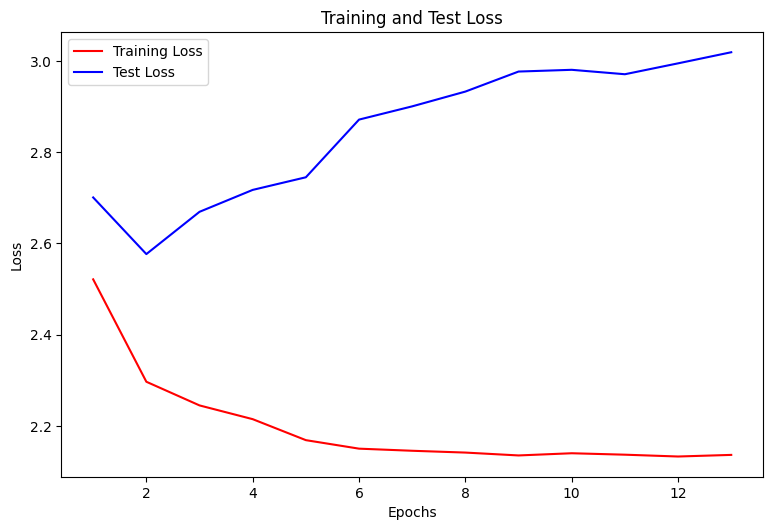

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import shutil
from torch.utils.tensorboard import SummaryWriter

def train(num_class, n_workers, batch_size, lr, epochs, log_dir, saved_model):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Initialize datasets
    train_dataset = ScannetDataset(transform=train_transform)
    train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_workers,
    drop_last=True  # This will drop the last batch if it's smaller than batch_size
    )

    test_dataset = ScannetDataset(is_train=False, transform=test_transform)
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        num_workers=n_workers
    )
    
    # Initialize model with correct number of classes
    model = PointNet(m=num_class).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=True)

    cm = ConfusionMatrix(num_classes=num_class)
    
    # Setup logging directories
    if os.path.isdir(log_dir):
        shutil.rmtree(log_dir)
    os.makedirs(log_dir)
    
    if not os.path.isdir(saved_model):
        os.makedirs(saved_model)
    
    writer = SummaryWriter(log_dir)

    train_loss = []
    test_loss = []
    train_loss_meter = AverageMeter()
    test_loss_meter = AverageMeter()

    best_mIoU = -1
    no_improvement_counter = 0
    patience = 10

    for epoch in range(epochs):
        model.train()
        train_loss_meter.reset()

        progress_bar = tqdm(train_loader, colour='cyan')

        for i, (feature, mask) in enumerate(progress_bar):
            feature, mask = feature.to(device), mask.to(device)

            output, _, _ = model(feature)
            
            # Reshape output and mask for segmentation
            output = output.transpose(2, 1)  # [B, num_classes, N] -> [B, N, num_classes]
            output = output.contiguous().view(-1, num_class)
            mask = mask.view(-1)
            
            loss = criterion(output, mask)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_meter.update(loss.item())
            progress_bar.set_description(f"Train | Epoch {epoch + 1}/{epochs} | Loss {train_loss_meter.avg:.4f} | lr {optimizer.param_groups[0]['lr']}")
            writer.add_scalar("Train/Loss AVG", train_loss_meter.avg, epoch * len(train_loader) + i)
            writer.add_scalar("Train/Loss", loss.item(), epoch * len(train_loader) + i)

        model.eval()
        with torch.no_grad():
            progress_bar = tqdm(test_loader, colour='yellow')

            for feature, mask in progress_bar:
                feature, mask = feature.to(device), mask.to(device)

                output, _, _ = model(feature)
                output = output.transpose(2, 1)  # [B, num_classes, N] -> [B, N, num_classes]
                output = output.contiguous().view(-1, num_class)
                mask = mask.view(-1)
                
                loss = criterion(output, mask)

                pred = torch.argmax(output, dim=1)
                
                cm.update(pred, mask)
                test_loss_meter.update(loss.item())

                progress_bar.set_description(f"Val | Loss {loss.item():.4f} | OA: {cm.overall_accuray:.2f}")

            miou, macc, over_all_acc, iou_per_cls, acc_per_cls = cm.all_metrics()
            print(f"Val | Loss {test_loss_meter.avg:.4f} | mIoU: {miou:.4f} | OA: {over_all_acc:.2f} | mACC: {macc:.2f}")
            writer.add_scalar("Val/Loss", test_loss_meter.avg, epoch)
            writer.add_scalar("Val/mIoU", miou, epoch)
            writer.add_scalar("Val/OA", over_all_acc, epoch)
            writer.add_scalar("Val/mACC", macc, epoch)

            scheduler.step(miou)

            checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch + 1,
                "mIoU": miou
            }

            torch.save(checkpoint, os.path.join(saved_model, "last.pt"))
            
            train_loss.append(train_loss_meter.avg)
            test_loss.append(test_loss_meter.avg)

            if best_mIoU < miou:
                best_mIoU = miou
                torch.save(checkpoint, os.path.join(saved_model, "best.pt"))
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1

            if no_improvement_counter > patience:
                print("Early stopping!")
                break

    plot_segmentation_metrics(train_loss, test_loss)

# Parameters
num_class = 41
n_workers = os.cpu_count()
batch_size = 2
lr = 1e-3
epochs = 30

# Local directory paths
log_dir = "./runs/tensorboard"
saved_model = "./saved_models"

# Create directories if they don't exist
os.makedirs(log_dir, exist_ok=True)
os.makedirs(saved_model, exist_ok=True)

train(num_class, n_workers, batch_size, lr, epochs, log_dir, saved_model)

## Inference

In [19]:
import torch
import matplotlib.pyplot as plt

def pred_show_image_grid(model_pth, device, test_dataset, num_classes, idx, num_imgs):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    model = PointNet().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    images, orig_masks, pred_masks = [], [], []
    
    with torch.no_grad():
        for i in idx[:num_imgs]:  # Chỉ hiển thị num_imgs đầu tiên
            ori_pc, orig_mask = test_dataset[i]  # Lấy point cloud và mask gốc
            
            # Chuẩn bị đầu vào
            pc = ori_pc.float().to(device).unsqueeze(0)
            
            pred_mask, _, _ = model(pc)  # B, C, N 
            pred_mask = torch.argmax(pred_mask, dim=1).squeeze(0)  # C, N
            pred_mask = pred_mask.cpu().numpy()  # N
            
            images.append(ori_pc.permute(1, 0).cpu().numpy())  # N, C
            orig_masks.append(orig_mask.cpu().numpy())  # N
            pred_masks.append(pred_mask)  # N
    
    # Hiển thị Point Cloud dưới dạng 2D
    plt.figure(figsize=(15, 5 * num_imgs))
    
    for i in range(num_imgs):
        # Point Cloud gốc
        pc = images[i] 
        orig_mask = orig_masks[i]  # Mask gốc
        pred_mask = pred_masks[i]  # Mask dự đoán

        colors = np.array([SCANNET_COLOR_MAP[m] for m in orig_mask])
        pred_colors = np.array([SCANNET_COLOR_MAP[m] for m in pred_mask])
        
        
        # Hiển thị điểm gốc
        ax = plt.subplot(num_imgs, 3, i * 3 + 1)
        plt.scatter(pc[:, 0], pc[:, 1], s=1, c='b')  # Không có màu
        ax.set_title("Original Point Cloud")
        ax.axis("equal")
        
        # Hiển thị mask gốc
        ax = plt.subplot(num_imgs, 3, i * 3 + 2)
        plt.scatter(pc[:, 0], pc[:, 1], c=colors / 255.0, s=1)
        ax.set_title("Original Mask")
        ax.axis("equal")
        
        # Hiển thị mask dự đoán
        ax = plt.subplot(num_imgs, 3, i * 3 + 3)
        plt.scatter(pc[:, 0], pc[:, 1], c=pred_colors / 255.0, s=1)
        ax.set_title("Predicted Mask")
        ax.axis("equal")
    
    plt.tight_layout()
    plt.show()

In [20]:
test_dataset = ScannetDataset(is_train=False, transform=test_transform)
test_dataset.__len__()

152



indexs = [4, 14, 24, 34, 44, 54, 66, 74, 84, 94]




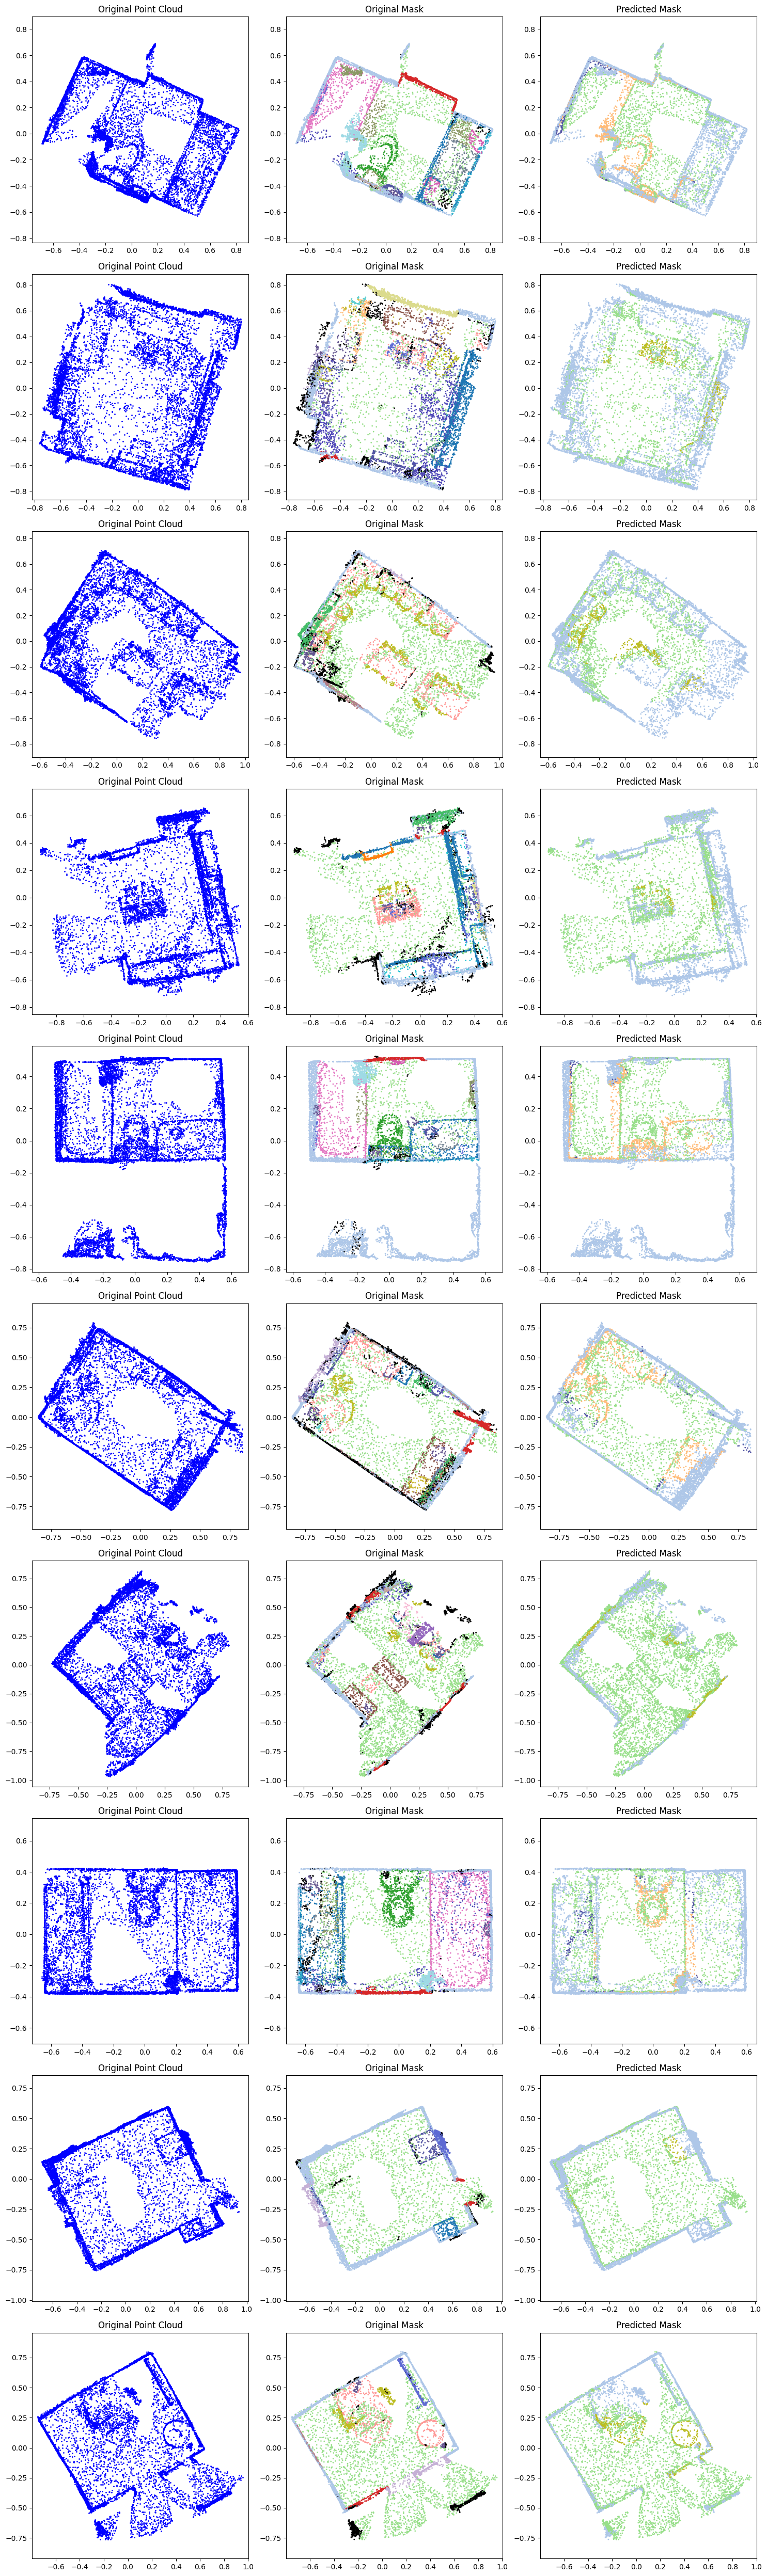

In [21]:
#Note: You must train the model before using this param
model_pth = "/home/tm/Desktop/dense_caption/saved_models/best.pt"
num_classes = 41
device = "cuda" if torch.cuda.is_available() else "cpu" 
print("\n")
indexs = [4, 14, 24, 34, 44, 54, 66, 74, 84, 94]
print("indexs =", indexs)
print("\n")

#Show images
pred_show_image_grid(model_pth, device, test_dataset, num_classes, indexs, num_imgs= 10)